# Изучение YOLO V5 - Быстре методы обнаружения объектов.
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1d--jyNUIyCfu7kqCzS_axSZTuJZFUID8#scrollTo=EFAO3VOrllIY)


В данном уроке мы будем использовать готовый репозиторий `Yolo V5`, представляющий собой фреймворк для обучения и работы соответствующего семейства моделей. Репозиторий мы скачаем при помощи команды `git clone`. Репозиторий будет скачен с официальной страницы разработчиков в [`GitHub`](https://github.com/ultralytics). Документация по семейству моделей `Yolo V5` может быть найдена [тут](https://docs.ultralytics.com/). Такж информация о команде `ultralytics` может быть найдена на их официальном сайте [тут](https://ultralytics.com/). 

В дополнении отметим, что помимо моделей `Yolo V5` команда `ultralytics` предоставляет семейство моделей `Yolo V3` c исппользованием аналогичного подхода, который мы изучим в этом уроке. Репозиторий `Yolo V3` можно найти по ссылке [тут](https://github.com/ultralytics/yolov3). 

Отметим, что в этом уроке мы рекомендуем работать в `Google Colab`, это связано с тем, что мы будем много пользоваться командной строкой и все действия отработаны именно под структуру `Google Colab`. 

В конце урока мы также покажем как использовать готовые модели `YOLO` в рамках `PyTorch`. 

Также укажем следующую ссылку [на официальный урок по YOLO V5](https://colab.research.google.com/github/ultralytics/yolov5/blob/master/tutorial.ipynb).

<!-- Напоммним, что  -->

In [1]:

import torch
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)


%cd /content/
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

try:
    import yolov5
except:
    pass


import os
os.kill(os.getpid(), 9)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-6-6 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



KeyboardInterrupt: ignored

После того, как репозиторий выгружен вы можете проверить его наличие вашей виртуальной машине, как это показано ниже.
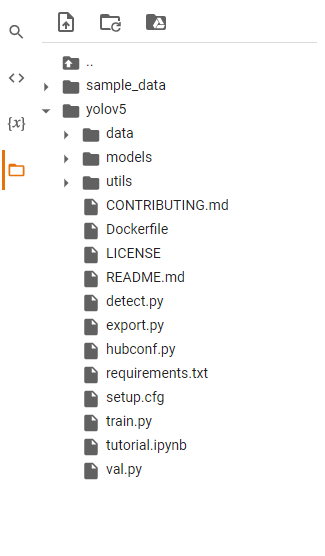

Попытаемся импортировать скаченный репозиторий. Для этого перейдем в соответствующую директорию при помощи команды `%cd /content/yolov5` и попытаемся импортировать библиотеку утилит.

Отметим, что помимо команд командной строки вы можете поменять директорию при помощи 

In [2]:
%cd /content/yolov5

import torch
from yolov5 import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 2022-6-6 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 38.7/78.2 GB disk)


Содержение репозитория может быть проверено при помощи команд bash

In [3]:
!pwd
!ls

/content/yolov5
CONTRIBUTING.md  export.py   models	       setup.cfg       utils
data		 hubconf.py  README.md	       train.py        val.py
detect.py	 LICENSE     requirements.txt  tutorial.ipynb


Теперь проведем импорт основных библиотек.

In [4]:
import os
import shutil
import torch
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import matplotlib.patches as patches
from google.colab.patches import cv2_imshow


In [5]:
def torch_stats(): 
    torch_version = ".".join(torch.__version__.split(".")[:2])
    print('PyTorch version:',torch_version)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)
    dtype = torch.float32

    if device.type == 'cuda':
        cuda_version  = torch.__version__.split("+")[-1]
        print("Cuda: ", cuda_version)

        torch.set_default_tensor_type(torch.cuda.FloatTensor)
        print('Cuda is available:',torch.cuda.is_available())

        n_devices = torch.cuda.device_count()
        print('number of devices: %d'%(n_devices))

        for cnt_device in range(n_devices):
            print(torch.cuda.get_device_name(cnt_device))
            print('Memory Usage:')
            print('Allocated:', round(torch.cuda.memory_allocated(cnt_device)/1024**3,1), 'GB')
            print('Cached:   ', round(torch.cuda.memory_reserved(cnt_device)/1024**3,1), 'GB')


    torch.set_default_dtype(dtype) # float32
    print('Default data type:',dtype)

    num_workers=os.cpu_count() #torch.get_num_threads()
    print ('Available number of workers:',num_workers)

    return device, dtype, num_workers
#-------------------------------
def torch_seed(seed = 42, deterministic = True):
    random.seed(seed) # random and transforms
    np.random.seed(seed) #numpy
    torch.manual_seed(seed) #cpu
    torch.cuda.manual_seed(seed) #gpu
    torch.backends.cudnn.deterministic=deterministic #cudnn    

In [6]:
torch.cuda.empty_cache()
device, dtype, num_workers = torch_stats()
torch_seed(seed = 42, deterministic = True)

PyTorch version: 1.11
Using device: cuda
Cuda:  cu113
Cuda is available: True
number of devices: 1
Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
Default data type: torch.float32
Available number of workers: 2


Перед началом работы с `YOLO` проверим работоспособность скаченного репозитория.  Для этого скачаем одно изображение из набора данных [`COCO`](https://cocodataset.org/#explore) и проверим, как работает модель. Напомним, что модели семейства `YOLO` изначально предобученны именно на этом наборе данных.

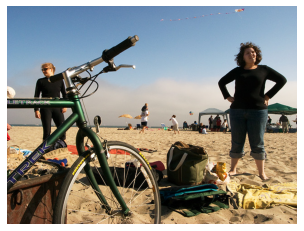

In [7]:
url = 'http://farm4.staticflickr.com/3190/2582737708_d323925200_z.jpg' 
if os.path.exists('/content/data/'):
  shutil.rmtree('/content/data/')
os.mkdir('/content/data/')
image_file = '/content/data/image.jpeg'
!wget -q -O {image_file} {url}
plt.imshow(Image.open(image_file)); plt.axis('off');plt.show()

Теперь проверим работу модели `YOLOV5s` (`small`) для тестового изображения. 
Само изображение лежит в диретории `data` (мы его скачали в эту директорию). 
Сеть в режиме детекции (рабочий режим) будет запущена при помощи скрипта `detect.py`, который находится в каталоге `yolov5`.
Результат работы сети по умолчанию будет находится в директории `../yolov5/runs/detect/exp/`.

Отметим, что информацию об официальном семействе моделей `YOLOV5` можно получить по [этой ссылке](https://github.com/ultralytics/yolov5#pretrained-checkpoints), а также на странице релизов [тут](https://github.com/ultralytics/yolov5/releases/).

Также отметим, спицифику запуска скрипта `detect.py` - он запускается с указанием ряда аргументов:<ul>
  <li> <code><b>--weights</code></b> - указание пути к файлу предобученнх весовых параметров, в нашем случае ```yolov5s.pt```; 
  <li> <code><b>--img</code></b> размер выходного изобаржения, в нашем случае 640 означет размер ```640x640```;
  <li> <code><b>--conf</code></b> пороговый уровень "уверенности", то есть значения взвешенного выхода классификатора, в нашем случае ```0.63```;
  <li> <code><b>--source</code></b> источник данных, в нашем случае  ```/content/data/```; 
  <li> <code><b>--exist-ok</code></b> если выходная директория (```../yolov5/runs/detect/exp/```) существует, переписать в нее.
<!-- Также отметим, что тут  мы используем команду `!rm -r -f /content/yolov5/runs/detect/*` перд запуском детектора, чтобы удалить директорию `../yolov5/runs/detect/exp/` в случае, если она уже создана. Это необходимо для сохранения заданных путей. -->


/content/yolov5
detect: weights=['yolov5s.pt'], source=/content/data/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.63, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-244-g47233e1 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

100% 14.1M/14.1M [00:00<00:00, 115MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
image 1/1 /content/data/image.jpeg: 480x640 6 persons, 1 bicycle, Done. (0.017s)
Speed: 0.5ms pre-process, 16.6ms inference, 54.5ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp


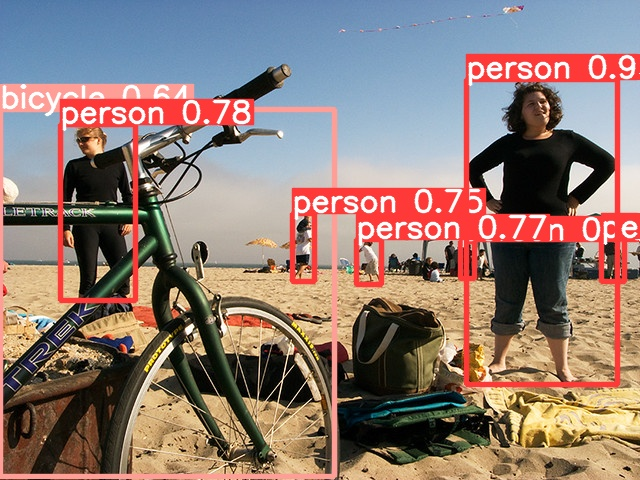

In [8]:
%cd /content/yolov5/
!python detect.py --weights yolov5s.pt --img 640 --conf 0.63 --source '/content/data/' --exist-ok

display.Image(filename='/content/yolov5/runs/detect/exp/image.jpeg', width=600)

Также проверим как выбранная модель `YOLO` будет работать в валидационном режиме.
Для это используем специально собранный набор данных  `COCO128`. Этот набор содержит 128 специально отобранных изображений из набора данных `COCO`.
Валидацию можно провести при помощи скрипта `val.py`.

<br> Скрипт можно вызвать со следующими аргументами: 
<ul>
  <li> <b><code>--data</code></b> путь к файлу вида <code>dataset.yaml</code>,  по умолчанию <code>ROOT/data/coco128.yaml</code>;
  <li> <b><code>--weights</code></b> путь к весам <code>model.pt</code>, по умолчанию <code>ROOT/yolov5s.pt</code>;
   <li> <b><code>--batch-size</code></b>,размер батча, по умолчанию = <code>32</code>;
   <li> <b><code>--imgsz, --img, --img-size</code></b> размер вывода (в пикселях), по умолчанию = <code>640х640</code>; 
   <li> <b><code>--conf-thres</code></b> порог достоверности, по умолчанию = <code>0.001</code>;
   <li> <b><code>--iou-thres</code></b> Порог <code>NMS IoU</code>, по умолчанию = <code>0.6</code>;
   <li> <b><code>--task</code></b> тип задачи, по умолчанию <code>val</code>, также возможны варианты <code>train, val, test, speed or study</code>;
   <li> <b><code>--device</code></b> тип устройства, по умолчанию <code>''</code>, также возможны значения <code>cuda devices</code>, т.е. 0 или 0,1,2,3 или <code>cpu</code>;
   <li> <b><code>--single-cls</code></b>, рассматривать датасет как набор данных одного класса;
   <li> <b><code>--augment</code></b>, расширенный вывод;
   <li> <b><code>--verbose</code></b>, сообщить значения метрикт <code>mAP</code> по классам;
   <li> <b><code>--save-txt</code></b>, сохранять результаты в <code>*.txt</code>;
   <li> <b><code>--save-hybrid</code></b>, сохранить гибридные результаты метки + прогноза в <code>* .txt</code>;
   <li> <b><code>--save-conf</code></b>, сохранить достоверность в ярлыках <code>--save-txt</code>;
   <li> <b><code>--save-json</code></b>, сохранить файл результатов в формате <code>COCO-JSON</code>;
   <li> <b><code>--project</code></b>, путь к результатов директории, по умолчанию = <code>ROOT/run/val</code>;
   <li> <b><code>--name</code></b>, default = <code>exp</code>, сохранить в <code>проект/имя</code>;
   <li> <b><code>--exist-ok</code></b>, существующий <code>проект/имя</code> перезаписать;
   <li> <b><code>--half</code></b>, использовать вывод половинной точности <code>FloatPoint16</code>;
   <li> <b><code>--dnn</code></b>, использовать <code>OpenCV</code> <code>DNN</code> для вывода в формате <code>ONNX</code>.
</ul>


Для проверки мы будем использовать маленькую модель  <code>yolov5s.pt</code>.

<em>Примечание</em> <ul>
<li> <b> Результаты проверки </b> сохраняются в <code>run/val/</code> с увеличивающимися номерами каталога выполнения, то есть <code>run/val/ exp2</code>, <code>run/val/exp3</code> и т.д.
<!-- <li> Вместо использования полного набора данных <code>COCO</code> мы можем проверить результаты на уменьшенной копии этого набора <code>COCO128</code>.     -->
<li> <b> Предварительно обученные модели </b> загружаются автоматически из последней версии репозитория <code>YOLOv5</code>. Список доступных для скачивания моделей вы можете найти в директории <code>../yolov5/models/</code> и <code>../yolov5/models/hub/</code> (файлы с расширением  <code>*.yaml </code>.    
<!-- <li> <b> Наборы данных </b>, доступные для автоматической загрузки, включают: <code> COCO, COCO128, VOC, Argoverse, VisDrone, GlobalWheat, xView, Objects365, SKU-110K </code>. --> 
<!-- <li> Вы можете найти всю доступную информацию о текущем состоянии Yolov5, используя страницу информации о  релизах <a href="https://github.com/ultralytics/yolov5/releases/">: 
    https://github.com/ultralytics/yolov5/Release/ </a> -->
    
<li> Также вы можете загрузить наборы данных <code> COCO </code> и <code> COCO128 </code> вручную. Например, для <code> COCO128 </code> вы можете использовать следующий код:

```python
# Download COCO val
torch.hub.download_url_to_file('https://ultralytics.com/assets/coco128.zip', 'tmp.zip')
!unzip -q tmp.zip -d ../datasets && rm tmp.zip
```
    

<!-- Отметим, что в данном случае мы также преварительно удалим директорию `runs/val/exp`, в случае ее существования. -->

In [9]:
!python val.py --weights 'yolov5s.pt' --data coco128.yaml --img 640 --iou 0.65 --half --exist-ok

val: data=/content/yolov5/data/coco128.yaml, weights=['yolov5s.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.65, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=True, half=True, dnn=False
YOLOv5 🚀 v6.1-244-g47233e1 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients

Dataset not found ⚠, missing paths ['/content/datasets/coco128/images/train2017']
100% 6.66M/6.66M [00:00<00:00, 7.98MB/s]
Dataset download success ✅ (1.9s), saved to /content/datasets
100% 755k/755k [00:00<00:00, 66.4MB/s]
val: Scanning '/content/datasets/coco128/labels/train2017' images and labels...128 found, 0 missing, 2 empty, 0 corrupt: 100% 128/128 [00:00<00:00, 1945.06it/s]
val: New cache created: /content/datasets/coco128/labels/train2017.cache
               Class     Images  

Директория результатов (`/content/yolov5/runs/val/exp/`) содержет некоторую отчетную информацию. Среди прочего в директории сохраняются изображения нескольких батчей с их разметкой. Посмотрим на содержание директории. Затем загрузим один из батчей.

In [10]:
!ls /content/yolov5/runs/val/exp/

confusion_matrix.png  R_curve.png	     val_batch1_pred.jpg
F1_curve.png	      val_batch0_labels.jpg  val_batch2_labels.jpg
P_curve.png	      val_batch0_pred.jpg    val_batch2_pred.jpg
PR_curve.png	      val_batch1_labels.jpg


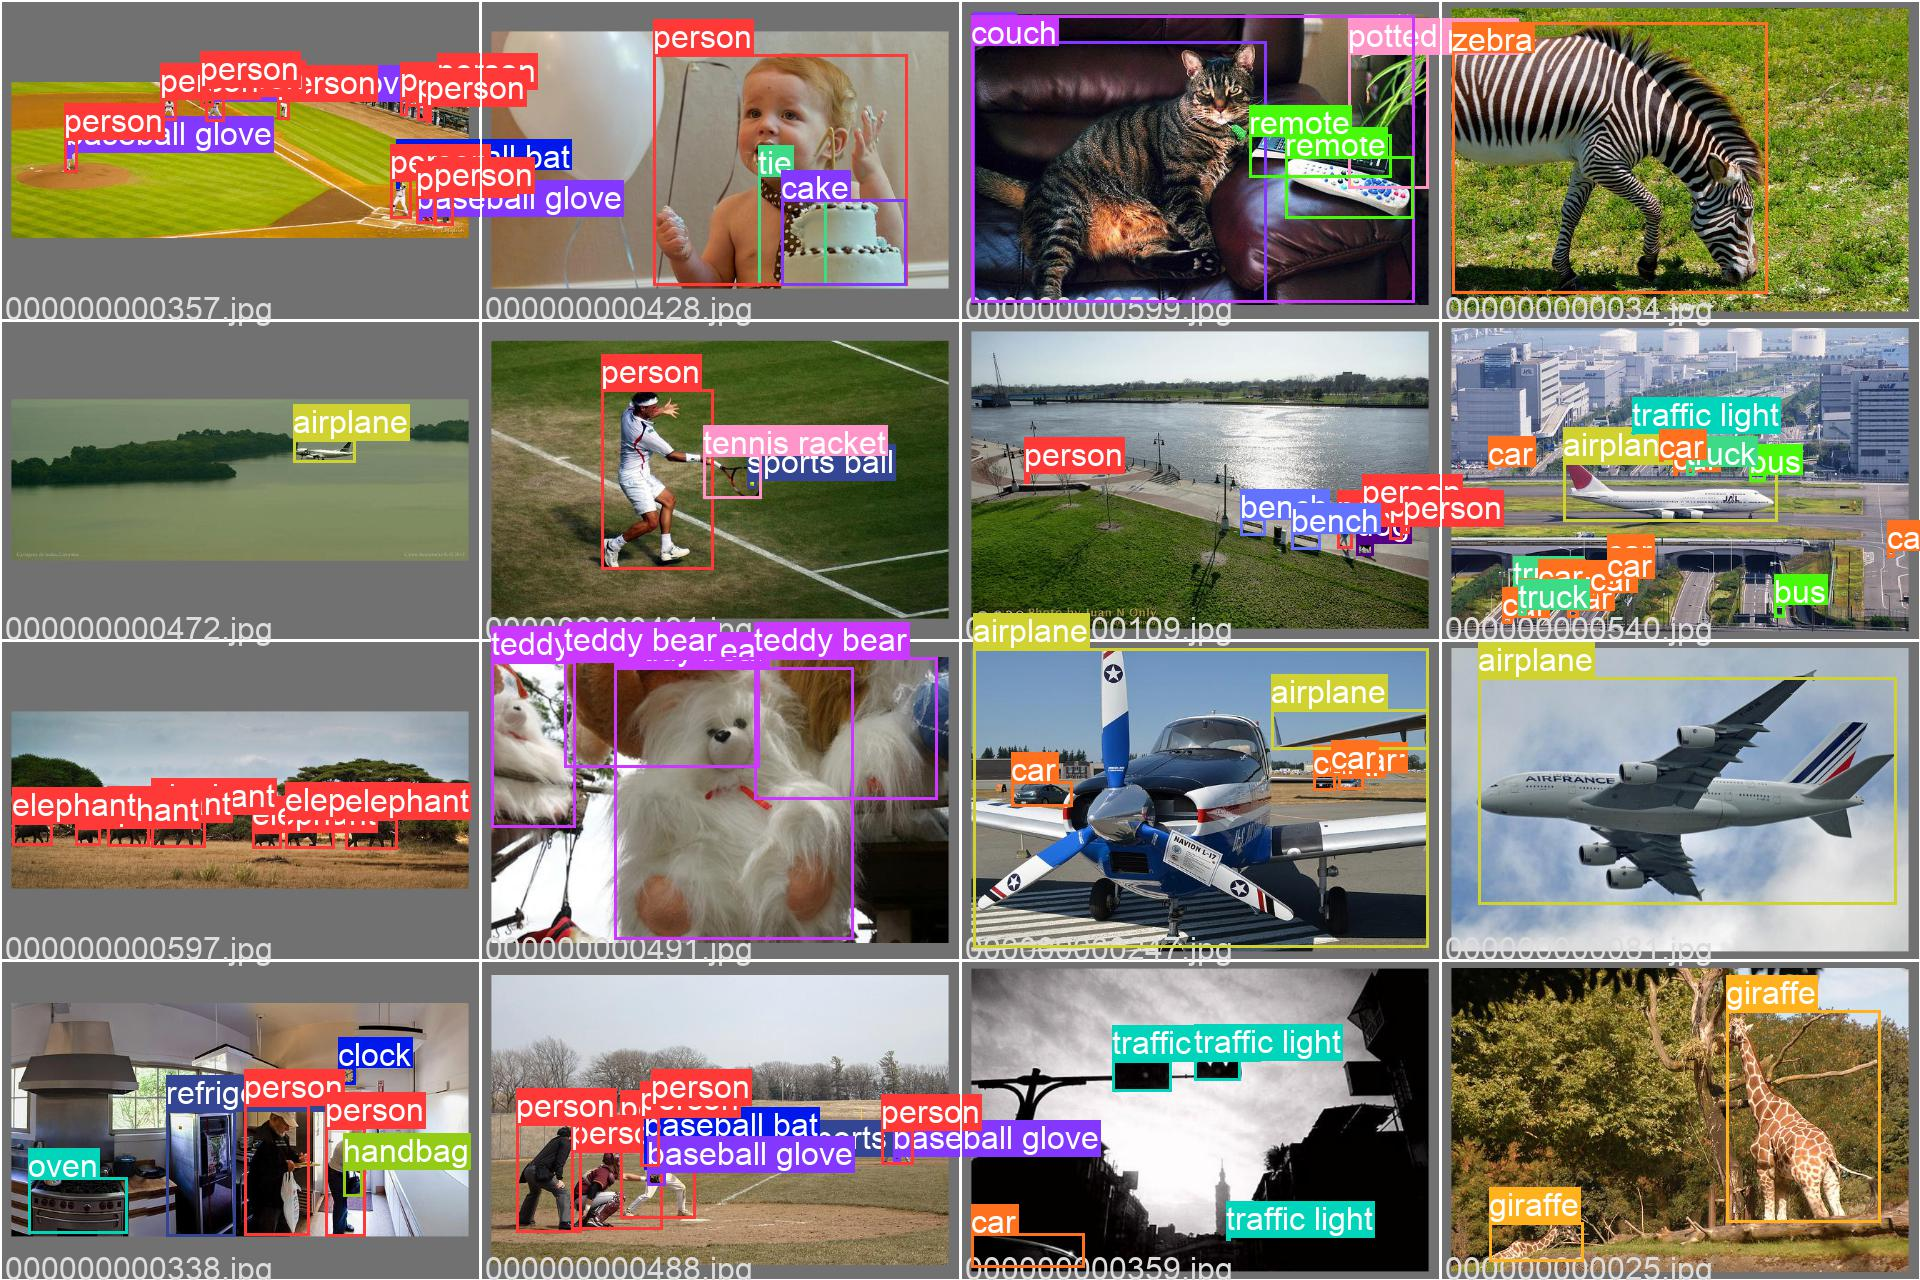

In [11]:
display.Image(filename='/content/yolov5/runs/val/exp/val_batch0_labels.jpg', width=1024)

<b>Тренировка</b> <br><br>
Для обучения модели `YOLO V5` можно воспользоваться подготовленным скриптом `train.py`б который также находится в директории `yolo`. Скрипт может быть запущен с одними из следующих параметров.
<ul>
  <li> <b><code>--weights</code></b>, путь к файлу начальных весов, по умолчанию <code>ROOT/yolov5s.pt</code>;
  <li> <b> <code>--cfg</code></b> путь к <code>model.yaml</code> для конфигурации модели;
  <li> <b><code>--data</code></b>, путь к файлу описания набора данных <code>dataset.yaml</code>, по умолчанию <code> ROOT/data/coco128.yaml</code>;
  <li> <b><code>--hyp</code></b> путь к файлу конфигурации гиперпараметров, по умолчанию <code>ROOT/data/hyps/hyp.scratch.yaml</code>;
  <li> <b><code>--epochs</code></b>, количество эпох обучения, по умолчанию <code>300</code>;
  <li> <b><code>--batch-size</code></b> размер батча (для всех графических процессоров), по умолчанию <code>16</code>, если аргумент выставлен<code>-1</code> осуществляется автоподбор;
<li> <b><code>--imgsz, --img, --img-size</code></b> размер изображения, по умолчанию <code>640x640</code>;
<li> <b><code>--resume</code></b> возобновить c последнеq точки обучение, по умолчанию <code>False</code>;
<li> <b><code>--nosave</code></b> сохранить только последнюю контрольную точку;
<li> <b><code>--device</code></b> выбор устройства, возможны варианты: <code>0 или 0,1,2,3</code> или <code>cpu</code>;
<li> <b><code>--multi-scale</code></b> варьировать размер изображения <code>+/- 50%</code>;
<li> <b><code>--single-cls</code></b> обучать данные с одним классом;
<li> <b><code>--adam</code></b> использовать оптимизатор <code>torch.optim.Adam</code>;
<li> <b><code>--label-smoothing</code></b> эпсилон сглаживания меток, по умолчанию <code>0.0</code>;
<li> <b><code>--patience</code></b>, раняя установка, если прошло не меньше установленного числа эпох без улучшений, по умолчанию 100;
<li> <b><code>--project</code></b>, сохранить в проект/имя, по умолчанию <code>ROOT/run/train</code>;
<li> <b><code>--name</code></b>сохранить в проект/имя, по умолчанию <code>exp</code>
<li> <b><code>--exist-ok</code></b> существующий проект/имя в порядке, без увеличения;
<li> <b><code>--save-period</code></b> cохранять контрольную точку каждые x эпох (отключено, если <code><1</code>);

<!-- <li> <b> прямоугольное обучение: </b> `--rect`, action = 'store_true' -->
<!-- <li> <b> проверять только последнюю эпоху: </b> `--noval`, action = 'store_true' -->
<!-- <li> <b> отключить автоматическую проверку привязки: </b> `--noautoanchor`, action = 'store_true' -->  
<!-- <li> <b> развивать гиперпараметры для поколений x: </b> `--evolve` -->
 <!-- nargs = '?', const = 300, -->

<!-- <li> <b> сегмент gsutil: </b> `--bucket`, default = '' -->

<!-- <li> <b> кэшировать изображения в "ram" (по умолчанию) или "disk": </b> `--cache`, nargs = '?', const = 'ram'-->

<!-- <li> <b> использовать вес для вероятности выбора изображений для обучения: </b> <code>--image-weights</code>; -->

<!-- <li> <b> использовать SyncBatchNorm, доступно только в режиме DDP: </b> `--sync-bn`, action = 'store_true' -->
    
<!-- <li> <b> максимальное количество рабочих загрузчиков данных: </b> `--workers`, по умолчанию = 8 -->


<!-- <li> <b> четырехъядерный загрузчик данных: </b> `--quad`, action = 'store_true' -->

<!-- <li> <b> линейный LR: </b> `--linear-lr`, action = 'store_true' -->



<!-- <li> <b> Количество слоев для закрепления. backbone = 10, all = 24: </b> `--freeze`, по умолчанию = 0 -->

<!-- <li> <b> Параметр DDP, не изменять: </b> `--local_rank`, default = -1 -->

<!-- <li> <b> W&B (аргументы веса и смещения) Entity: </b> `--entity`, по умолчанию = None
<!-- 
<li> <b> W&B: загрузить набор данных как таблицу артефактов: </b> `--upload_dataset`, action = 'store_true' -->

<!-- <li> <b> W&B: установить интервал регистрации изображения ограничивающего прямоугольника: </b> `--bbox_interval`, по умолчанию = -1 -->

<!-- <li> <b> W&B: версия артефакта набора данных для использования: </b> `--artifact_alias`, default = 'latest' -> -->

<em>Примечание</em> <br> Вы можете найти остальные параметры в `train.py` в форме, подобном: <br>```parser.add_argument ('- freeze', default = 0, 'Number of Layers to freeze . backbone = 10, all = 24 ') ```

Рассмотрим пример обучения модели `YOLOv5s` на наборе данных `Balloon` (надувные шары). Этот набор данных был использован нами в примере работы с многоэтапными подходами решения задач обнаружения объектов. Теперь у вас будет возможность сравнить точность, удобство и скорость работы быстрого и многоэтапного подходов.


Перед тем, как обучить модель, давайте скачаем набор данных.

In [12]:
from urllib.request import urlretrieve
from torchvision.datasets.utils import download_and_extract_archive

In [13]:
url = "https://github.com/matterport/Mask_RCNN/releases/download/v2.1/balloon_dataset.zip"

root_directory = os.path.join(os.getcwd(),'/content/data')

archive_name = url.split('/')[-1]
dataset_directory = os.path.join(root_directory, archive_name)
# dataset_directory = os.path.splitext(dataset_directory)[0]
dataset_directory = os.path.join(root_directory, 'balloon')

download_and_extract_archive(url, root_directory)

  0%|          | 0/38741381 [00:00<?, ?it/s]

Extracting /content/data/balloon_dataset.zip to /content/data


Теперь преобразуем набор в формат `YOLO`. Этот формат предполагает, что к каждому изображению будет создан файл разметки в форате `*.txt`.<br>
 Файл разметки должен содержать строки в формате <ul> 
  <code> {класс} {xc} {yc} {w} {h}</code><br>
  <code> {класс} {xc} {yc} {w} {h}<br>
  ...
  </code>
     </ul>
  где `xc` и `yc` - координаты центра каждого объекта; `w` и  `h` - ширина и высота каждого объекта. Все величины должны быть заданы в относительных еденицах. Перенос строк (у нас их две) может быть выполнен при помощи символа конца строки `\n`.
  
Для удобства освоения данного формата мы создадим две фунции: первая для перевода координат, полученных из первоначальной разметки (`balloon`) в формат `YOLO` и вторая для перевода из формата  `YOLO` в формат `COCO`, который рассмтаривался в премерах с многоэтапным подходом. Просим, также, обратить внимание, что в YOLO, и соотвественно в наших функциях сначала идет `width`, потом `heigh`, а в формате представления изображений `torch` и `numpy` наоборот. 

Также создадим функцию `create_anno` которая будет создавать файлы аннотации для каждого файла изображений в соответствующих директориях.

In [14]:
import json

def balloon2yolo(xmin,ymin, xmax, ymax, image_width, image_height):  
    x = (xmin + xmax)/2.0/image_width
    y = (ymin + ymax)/2.0/image_height
    w = (xmax - xmin)/image_width
    h = (ymax - ymin)/image_height
    return x,y,w,h

def yolo2coco(xc, yc, w, h, image_width, image_height):
    xc, w = xc*image_width,  w*image_width
    yc, h = yc*image_height, h*image_height
    xmin = xc - w//2
    ymin = yc - h//2
    return xmin,ymin,w, h

def create_anno(img_dir):
    anno_path = os.path.join(img_dir, 'via_region_data.json')
    with open(anno_path) as f:
        imgs_anns = json.load(f)
    img_pths = []
    ann_pths = []
    for idx, ann in enumerate(imgs_anns.values()):
        file_image = os.path.join(img_dir, ann["filename"])
        file_ann = os.path.splitext(file_image)[0]+'.txt'
        img_pths +=[file_image]
        ann_pths +=[file_ann]
        height, width = np.asarray(Image.open(file_image)).shape[:2]
        annos = ann["regions"]
        string = ''
        for _, anno in annos.items():
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            xmin, xmax  = np.min(px), np.max(px)
            ymin, ymax  = np.min(py), np.max(py)
            x,y,w,h = balloon2yolo(xmin,ymin, xmax, ymax, width, height)
            category_id = 0
            content =f"{category_id} {x} {y} {w} {h}\n"
            string = string + content
        with open(file_ann, 'w') as f:
            f.write(string[:-1])#without last '\n' symbol
    return img_pths, ann_pths

Проверим, что директории созданы правильно и создадим аннотации. Функция `create_anno` возвращает списки путей к изображениям и путей к их аннотациям.

In [15]:
val_dir   = os.path.join(dataset_directory, 'val')
train_dir = os.path.join(dataset_directory, 'train')

val_img,     val_ann = create_anno(val_dir)
train_img, train_ann = create_anno(train_dir)

print('train length:\t',len(train_img),  '\nval length:\t',len(val_img))

train length:	 61 
val length:	 13


Попробуем визуализировать результат создания набора данных. Для этого напишем функцию считывающую разметку из аннотаций формата `YOLO`. А также создадим функцию `plot_bbox` для визуализации.

In [16]:
def get_ann(ann_pth):
    with open(ann_pth, 'r') as f:
        data = f.read()
    return [list(map(float, string.split(' '))) for string in data.split('\n')]

In [17]:
data = get_ann(val_ann[1])
print(np.asarray(data)[:,1:])

[[     0.4069     0.13623     0.14583      0.1084]
 [    0.53418       0.125     0.11654    0.041992]
 [    0.53027     0.18042     0.15169      0.1167]
 [    0.60026     0.29004    0.091146     0.11133]
 [    0.53027     0.28979     0.16211     0.14111]
 [    0.39518     0.23511     0.15234     0.14014]
 [    0.43229     0.33398     0.13151    0.085938]]


In [18]:
def plot_bbox(image_pth, ann_pth = None):
    image =  np.asarray(Image.open(image_pth))

    height, width = image.shape[:2]

    if ann_pth is None:
        ann_pth = os.path.splitext(image_pth)[0]+'.txt'
    bbox   = np.asarray(get_ann(ann_pth))[:,1:]

    fig, axs = plt.subplots(1, 2, figsize = (8,4))
    image_ = np.copy(image).astype(float)/image.max()
    
    # Ground Truth    
    axs[0].imshow(np.clip(image_,0,1), 'gray')
    axs[0].axis('off'); axs[0].set_title('Original Image')
    #----------------------------
    
    # Object Detection BBoxes
    axs[1].imshow(np.clip(image_,0,1), 'gray')
    for box in bbox:
        xmin,ymin,w,h = yolo2coco(*box, width,height)
        bb = patches.Rectangle(xy     = (xmin,ymin), 
                               width  = w,height = h, 
                               linewidth=2, edgecolor="blue", facecolor="none")
        axs[1].add_patch(bb)  
    axs[1].axis('off'); axs[1].set_title('Object Detection')

    plt.tight_layout()
    plt.show()

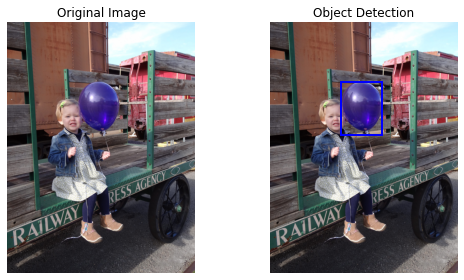

In [19]:
plot_bbox(train_img[2])

Теперь попробуем проверить точность работы выбранной модели для наших данных "по умолчанию" - то есть перед началом тренировки.

/content/yolov5
detect: weights=['yolov5s.pt'], source=/content/data/balloon/train/24362039530_b151b41a52_k.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.63, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-244-g47233e1 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
image 1/1 /content/data/balloon/train/24362039530_b151b41a52_k.jpg: 640x480 1 person, Done. (0.017s)
Speed: 0.5ms pre-process, 16.5ms inference, 1.2ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp


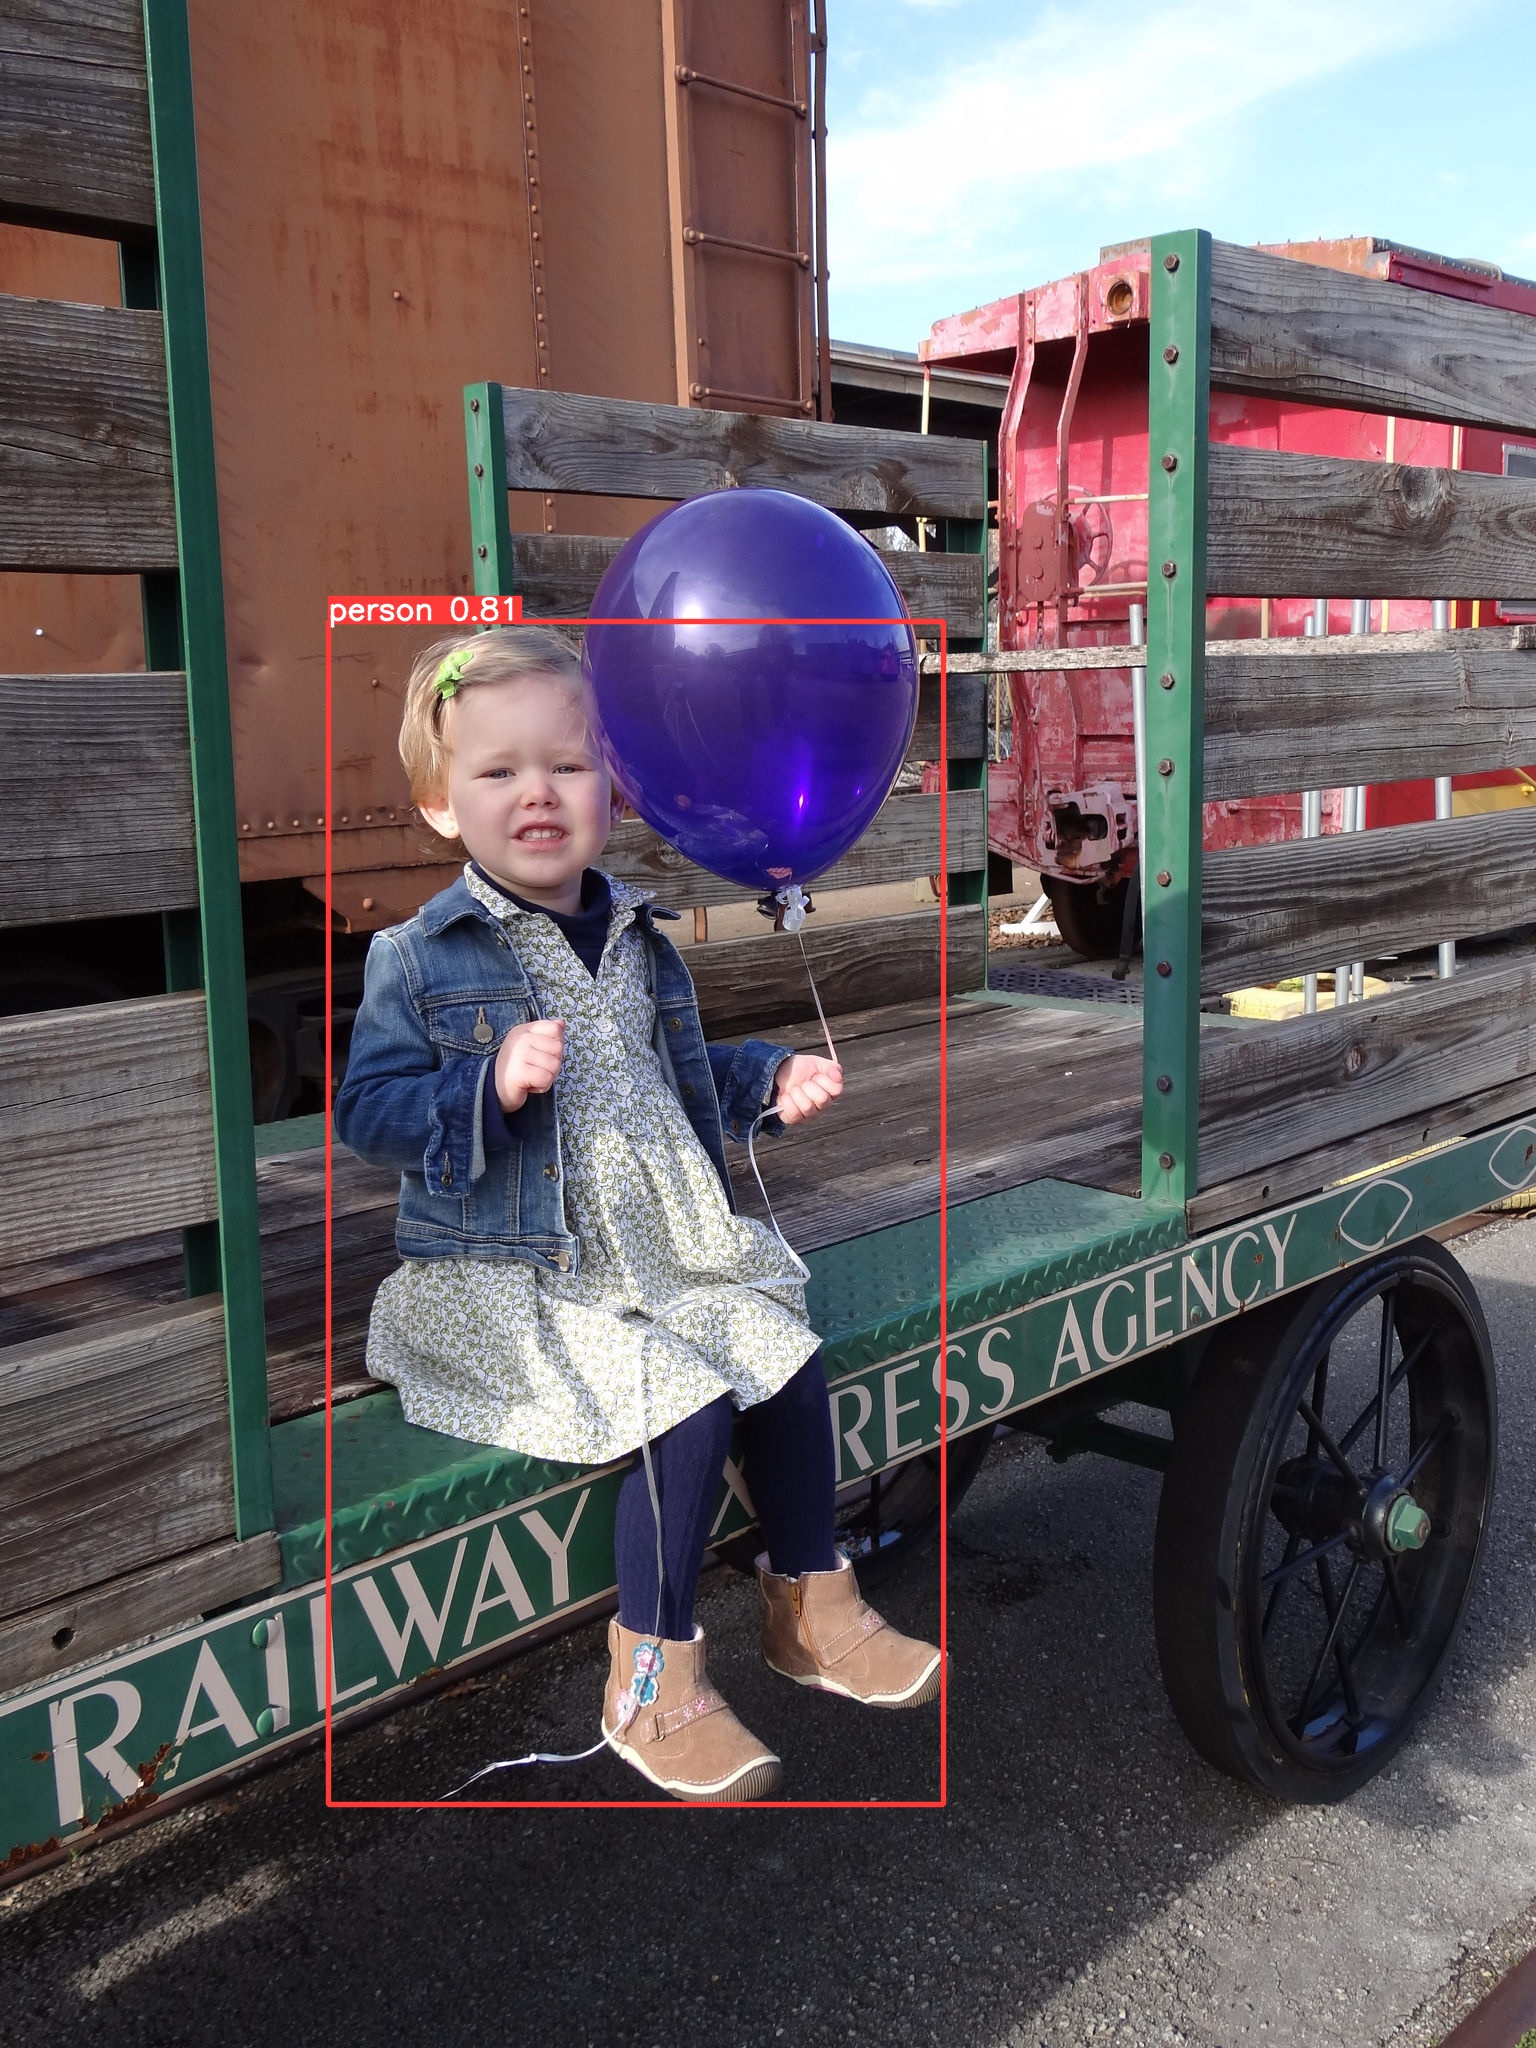

In [20]:
%cd /content/yolov5/
!python detect.py --weights yolov5s.pt --img 640 --conf 0.63 --source '/content/data/balloon/train/24362039530_b151b41a52_k.jpg' --exist-ok

display.Image(filename='/content/yolov5/runs/detect/exp/24362039530_b151b41a52_k.jpg', width=240)


Как и следовало ожидать сеть, предобученная на наборе данных `COCO` прекрасно справилась с выделением человека, но несмогла найти воздушный шар. Теперь попытаем переобучить выбранную модель.

Перед началом тренировки модели создадим файл с описанием набора данных `*.yaml`, путь к этому файлу необходимо будет указать в качестве аругмента при тренировке модели. В этом файле будут описаны названия классов (`names`), их число (`nc`), а также пути к тренировочному, валидационному и тестовому наборам данных. Однако, в нашем случае мы не будем указывать последний за неимением.

Также ометим, что описание набора данных может быть более широким. Примеры файлов `*.yaml` для базовых наборов данных можно найти в директории `../yolov5/data/`.
 <!-- А также в директории `scripts` можно найти примеры скриптов для скачивания файлов. -->

In [21]:
data_yaml_path = os.path.join('/content/data/balloon','data_.yaml' )

string = '''names:
- '0'
nc: 1
train: /content/data/balloon/train
val: /content/data/balloon/val
'''
with open(data_yaml_path,'w') as f:
  f.writelines(string)
  f.close()

Перед тренеровкой давайте очистим директорию `runs` от результатов наших предыдущих экспериментов. Это будет необходимо так как мы будем записывать результаты по тем же путям, что ранее - то есть мы действуем так, чтобы не спутаться. 

In [22]:
!rm -rf /content/yolov5/runs/*

Теперь перейдем к самой процедуре тренеровки. Данные описаны в файле ` /content/data/balloon/data_.yaml`, начальные весовые параметры `--weights yolov5s.pt`.
<b> Результаты обучения </b> сохраняются в <code>runs/train/exp</code>. Тренеровка будет проводить с размером батча `16` на `30` эпохах. Размер входонго изображения будет преобразован в `640x640`.

Отметим, что если убрать аргумент `--exist-ok`, то последующие эксперменты будут сохраняться в каталогах с увеличением номера, например, <code>runs/train/exp2</code>, <code>run/train/exp3</code> и т. д.



Также отметим, что при необходимости могут быть отрегулированы некоторые гиперпараметры обучения модели. Используемые параметры обучения могут быть найдены в директории проекта, например, <code>run/train/exp</code> в файле `hup.yaml`. Параметры деляться на несколько групп. <ul>
  <li> Параметры скорости обучения: начальная скорость `lr0`; скорость в конце `lrf`; момент для `SGD` `momentum`; регуляризация `SGD`: `weight_decay`; параметры `warmup` (если это необходимо).
  <li> Параметры конфигурирования функции потерь, например, веса для значений `box_loss` или `class_loss`, а также, например, пороги `IoU` (`iou_t`) и число анхоров на участок изображения `anchors`.
  <li> Параметры агументации: агументации в формате изображения `HSV`; афинные преобразования (поворотов; масштаб, сдвиг, перспектива, отражение); метод аугментации `mosaic` (сбор изображения из 4 в определенных пропорциях) и `mixup` (наложение двух изображений с определенными коэффициентами).


Более подробная информация о создании совего файла настройки гиперпараметров может быть найдена в официальной документации [тут](
https://docs.ultralytics.com/tutorials/hyperparameter-evolution/). Также отметим, что в директории `../yolov5/data/hyp/` можно найти ряд сформированных наборов гиперпараметров для решения некоторых задач. По умолчанию используется набор `../yolov5/data/hyp/hyp.scratch-low.yaml`.



In [23]:
%cd /content/yolov5/

!python train.py --img 640 --batch 16 --epochs 30 --data /content/data/balloon/data_.yaml --weights yolov5s.pt --exist-ok

/content/yolov5
train: weights=yolov5s.pt, cfg=, data=/content/data/balloon/data_.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=30, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=True, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-244-g47233e1 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0

Рассмотрим структуру отчета о тренировке: в отчете указываются: <ul>
  <li> Для режима тренировки: <ul>
      <li> номер эпохи (<code>Epoch</code>); 
      <li> используемая память (ОЗУ, <code>gpu_mem)</code>;
      <li> значения функций потерь (<code>box, obj, cls</code>);
      <li> число заявленных объектов для всех изображений (<code>labels</code>);
      <li> размер изображения (<code>img_size</code>);
      <li> число батчей и время работы;
    </ul>
  <li> Для режима тестирования (валидации): <ul>
    <li> использованнеы классы (<code>Class</code>);
    <li> число изображений (<code>Images</code>);
    <li> число заявленных объектов (<code>Labels</code>);
    <li> точность (<code>presiccion, P, (True Positive)/(True Positive + False Positive)</code>);
    <li> полнота (<code>recall, R, (True Positive)/(True Positive + False Negative)</code>);
    <li> средняя метрика точности (<code>mAP, mean Average Precision</code>) по уровню порового <code>IoU 0.5</code>;
    <li> средняя метрика точности (<code>mAP, mean Average Precision</code>) по уровням порового <code>IoU 0.5:0.95</code> c шагом <code>0.05</code>;
    <li> число батчей и время работы.

При помощи функции `plot_results` из набора утилит `yolov5` посмотрим на итоги обучения. Сами по себе результаты хранятся в файле `results.csv` в директории проекта (в нашем случае `/content/yolov5/runs/train/exp`).

/content/yolov5


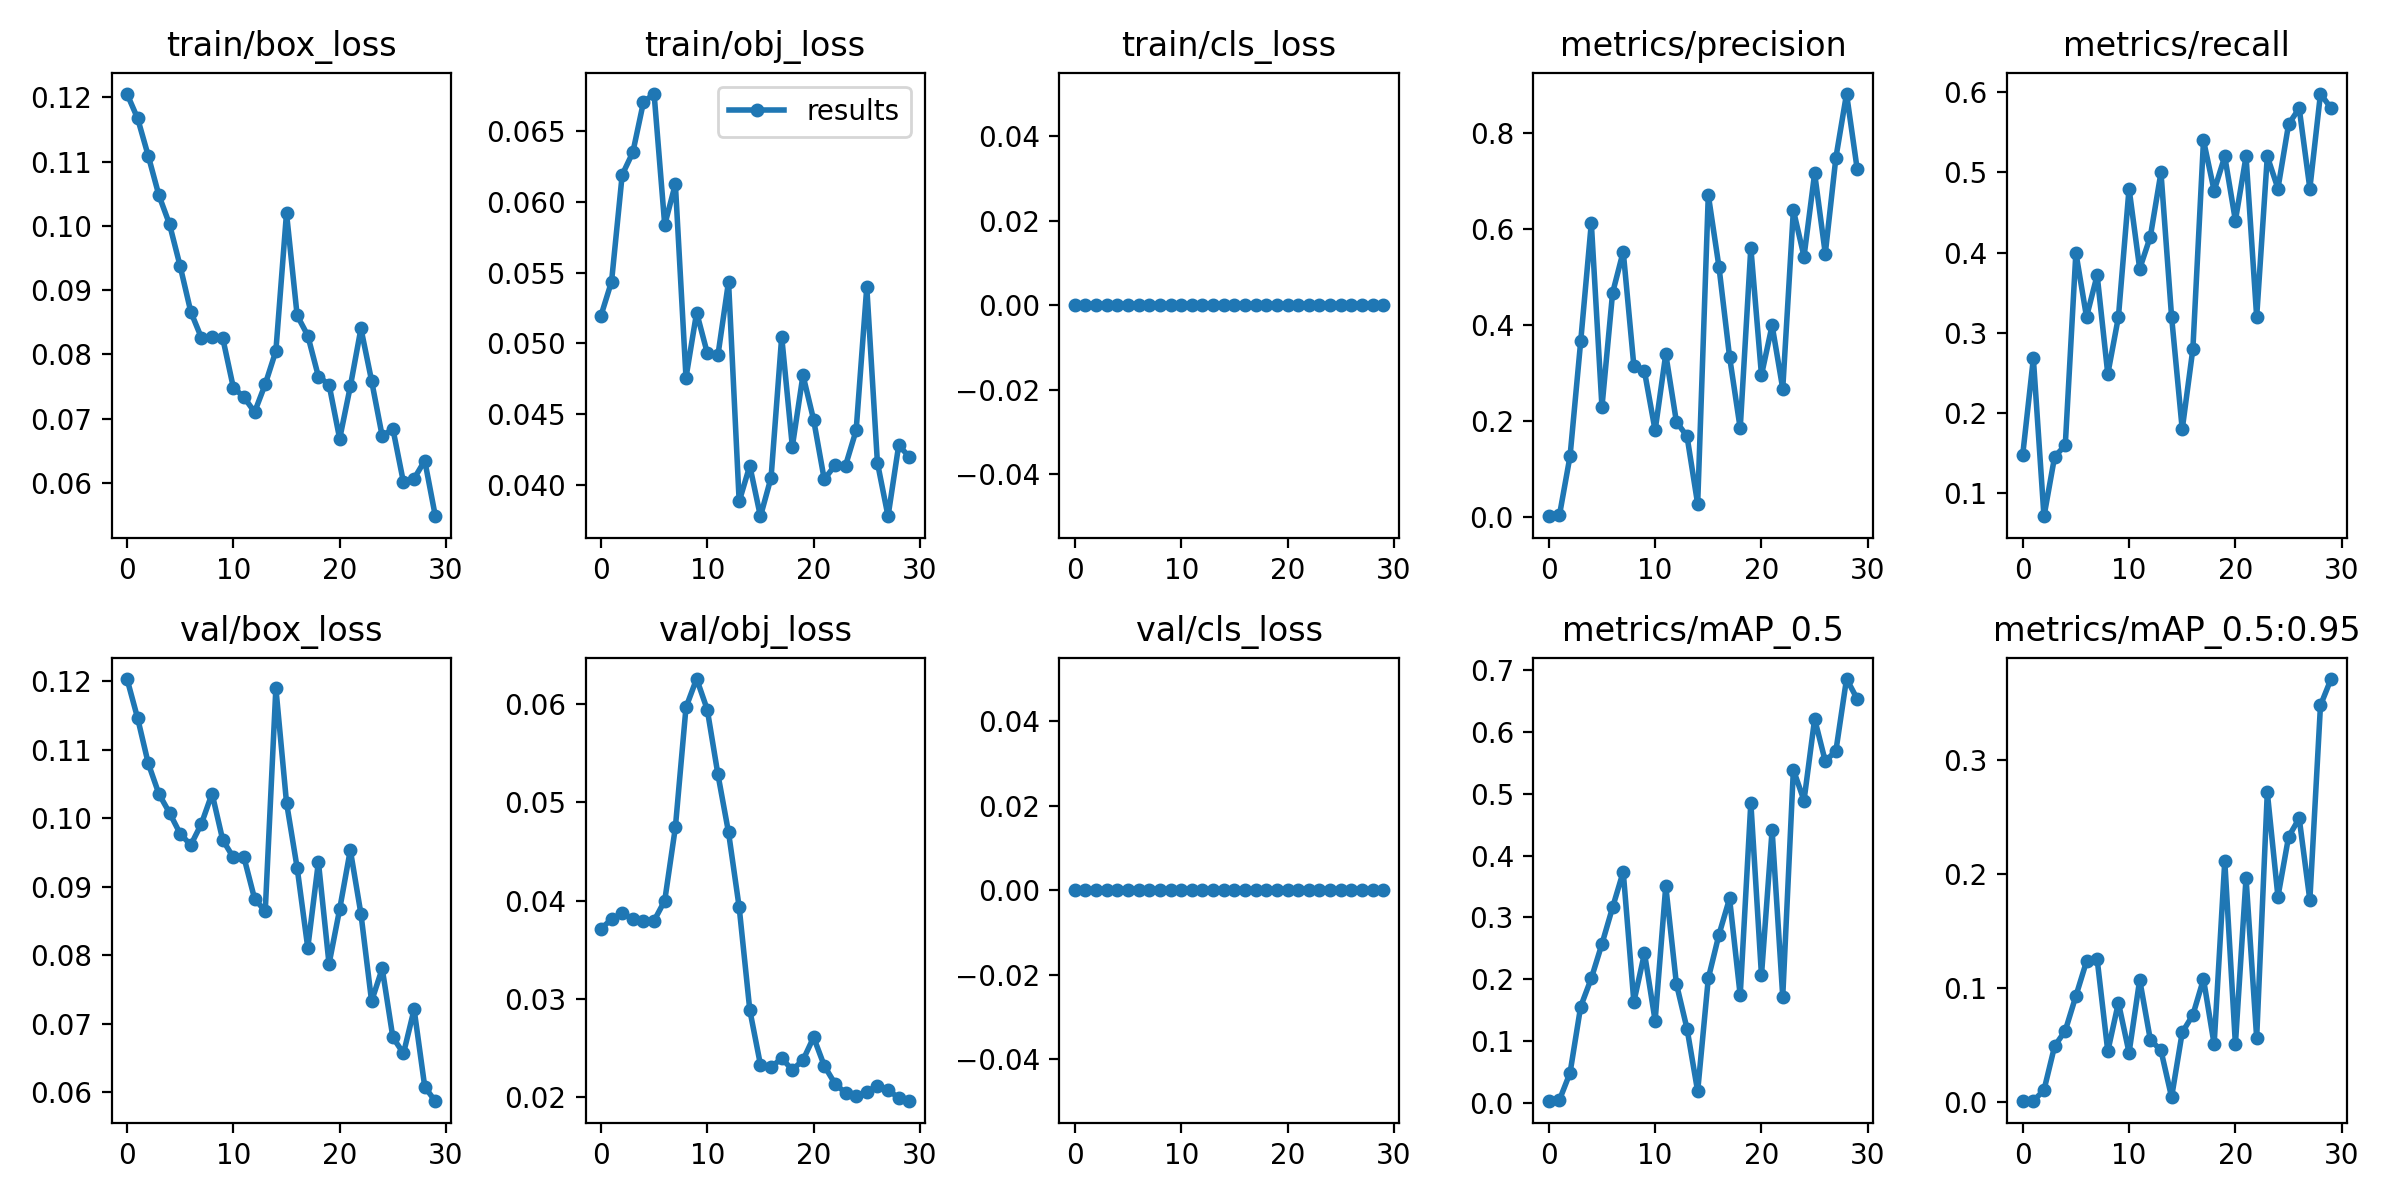

In [24]:
%cd /content/yolov5/
from utils.plots import plot_results 
plot_results('/content/yolov5/runs/train/exp/results.csv')  # plot 'results.csv' as 'results.png'
display.Image(filename='/content/yolov5/runs/train/exp/results.png', width=640)

Также отметим, что по мимо описанного в указаной директории можно найти следующую информацию: файл с поисанием особенностей проекта `opt.yaml`; текущие и лучшие по показателю `mAP` значения весовых параметров (в директории `weights`); примеры работы сети на тренировочных батчах (например, `train_batch0.jpg`, а также некоторую информацию о метках (`labels`).

Проверим точность на валидационного наборе данных. Для этого запустим скрипт `val.py` c указанием весовых параметров лучшей из эпох обучения `/content/yolov5/runs/train/exp/weights/best.pt`.

In [25]:
!python val.py --weights /content/yolov5/runs/train/exp/weights/best.pt --data /content/data/balloon/data_.yaml --img 640  --iou-thres 0.15 --conf-thres 0.65 --exist-ok

val: data=/content/data/balloon/data_.yaml, weights=['/content/yolov5/runs/train/exp/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.65, iou_thres=0.15, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=True, half=False, dnn=False
YOLOv5 🚀 v6.1-244-g47233e1 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning '/content/data/balloon/val.cache' images and labels... 13 found, 0 missing, 0 empty, 0 corrupt: 100% 13/13 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100% 1/1 [00:01<00:00,  1.23s/it]
                 all         13         46      0.938      0.652       0.81      0.488
Speed: 0.3ms pre-process, 8.7ms inference, 1.5ms NMS per image at shape (32, 3, 640, 640)
Results s

Также мы можем посмотреть визуальный результат, которй в нашем случае находится в директории `/content/yolov5/runs/val/exp/`. 

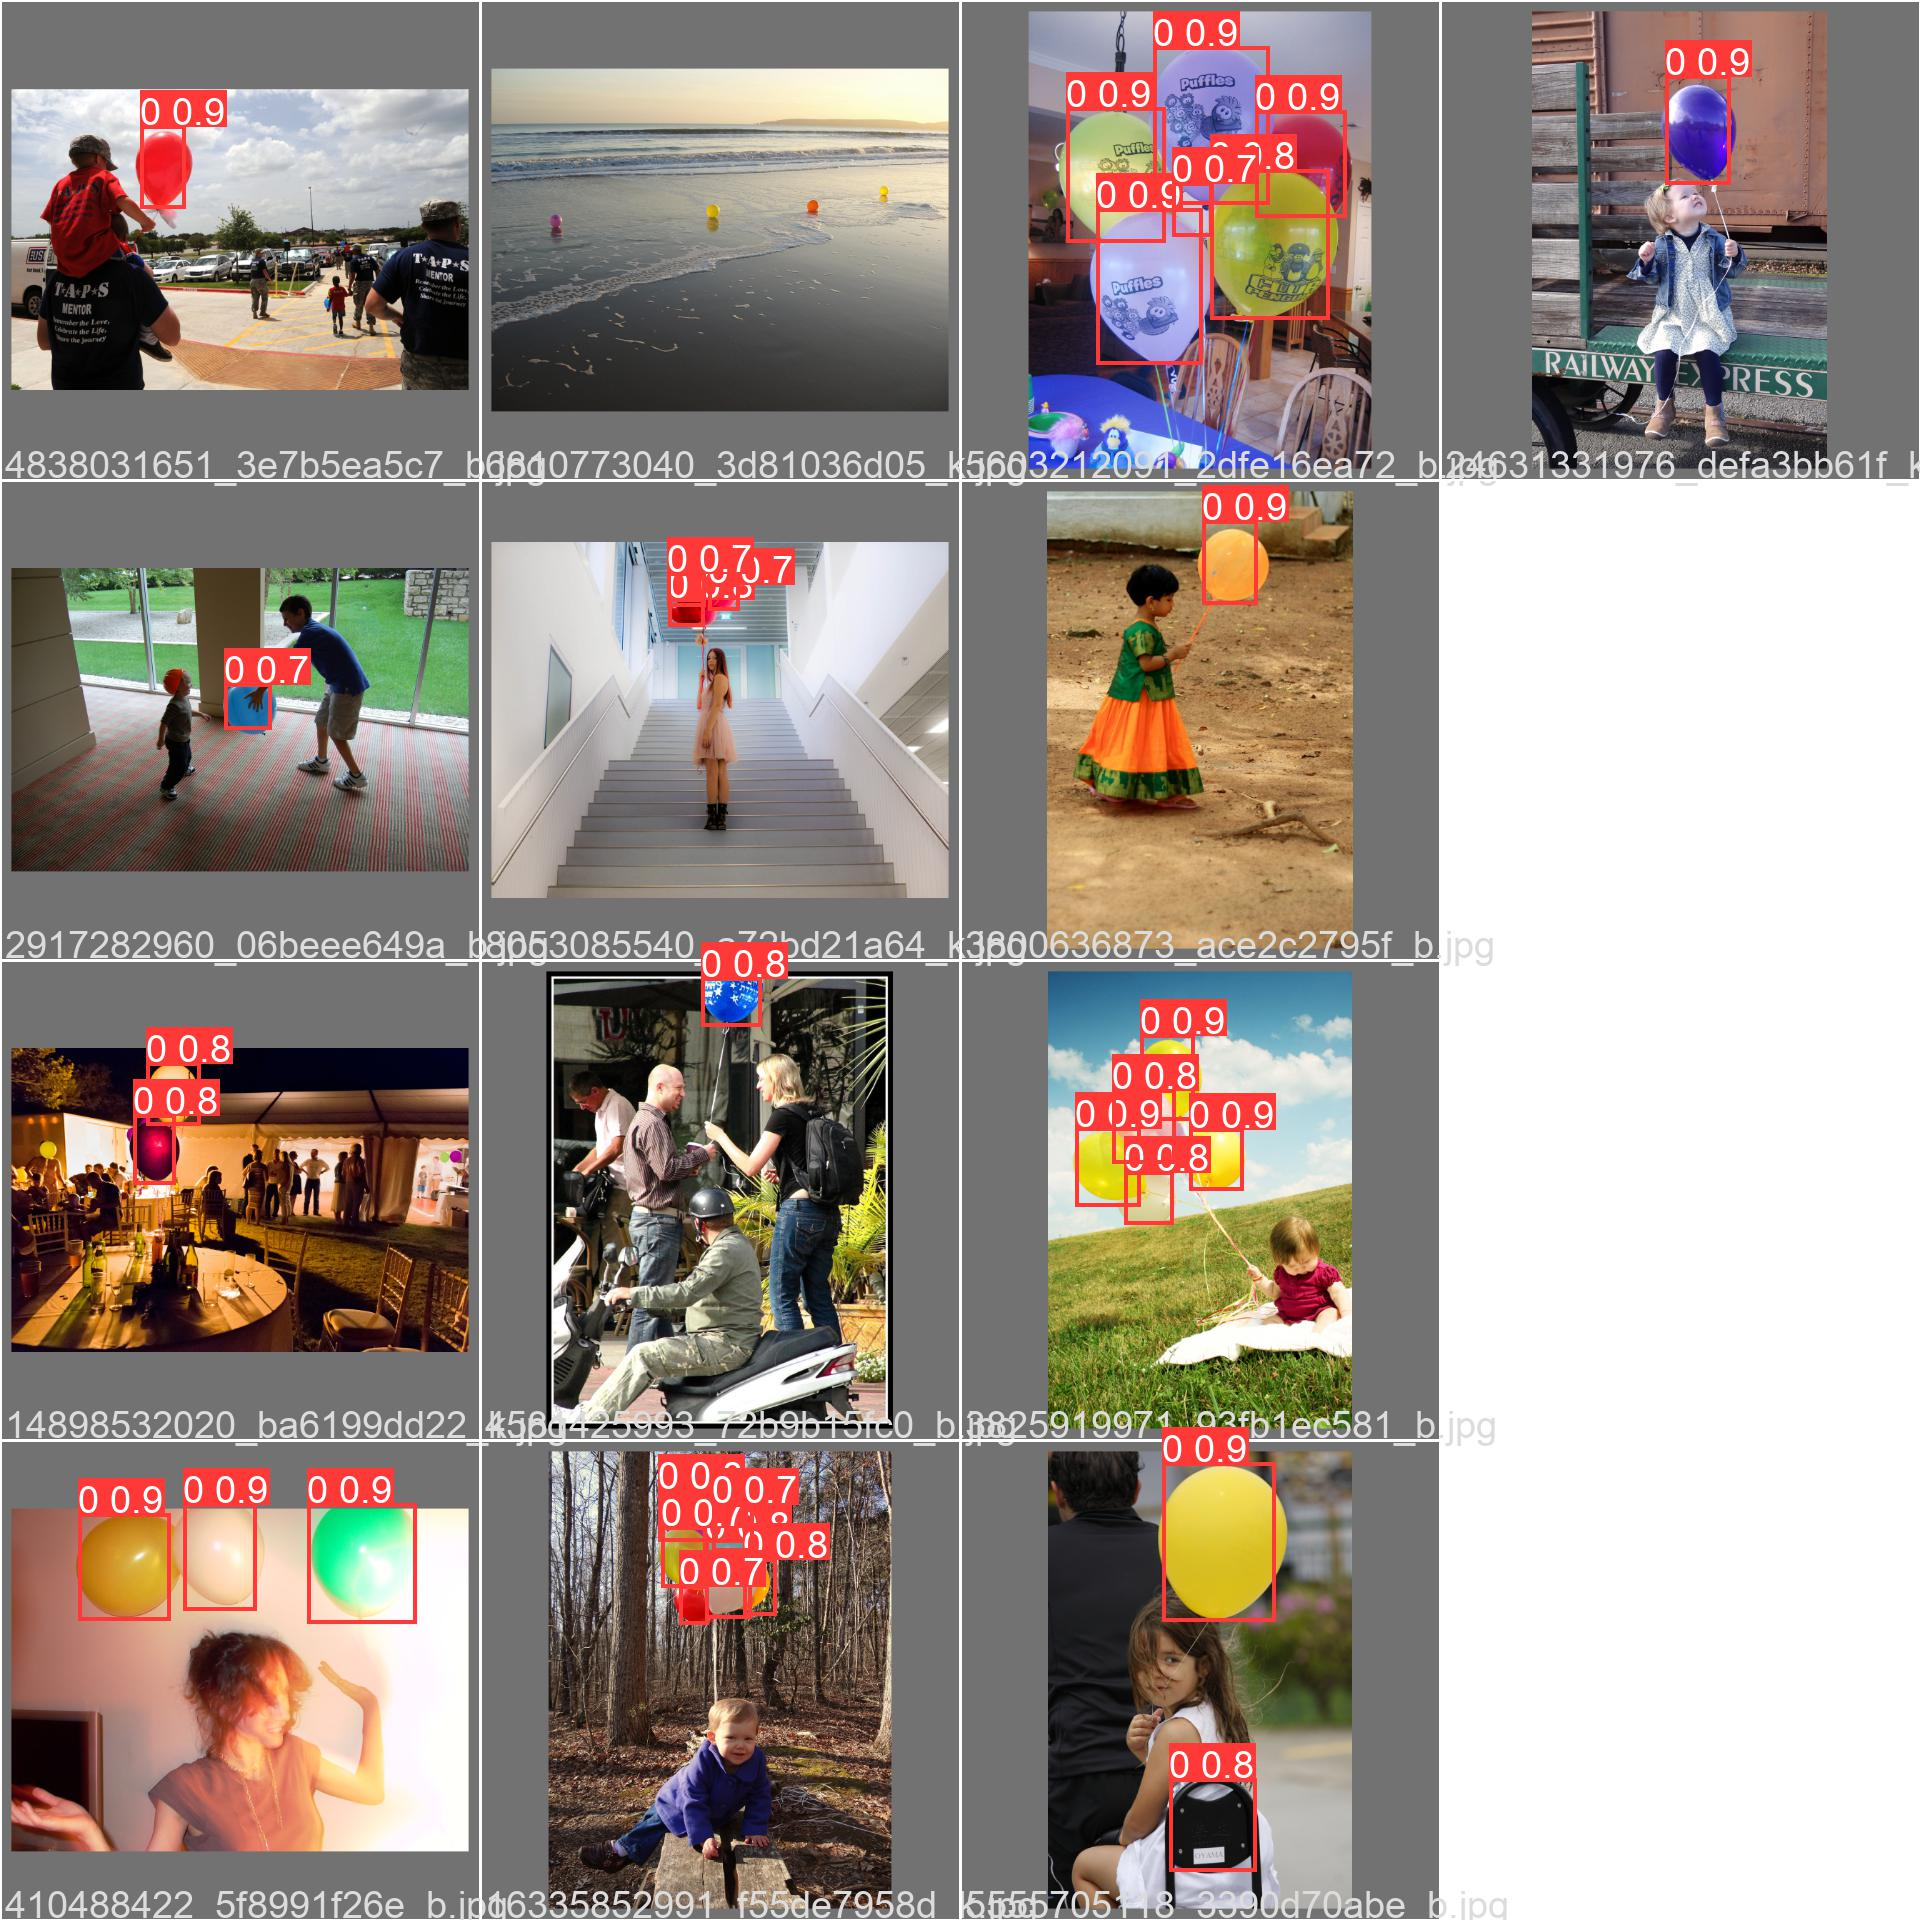

In [26]:
display.Image(filename='/content/yolov5/runs/val/exp/val_batch0_pred.jpg', width=540)

Отметим, также, что результаты работы модели могу быть экспорированы в другие форматы при помощи скрипта `export.py`. Однако, на разборе всех возможных форматов экспорта мы на этом пункте останавливаться не будем. 

Обученные модели `yolo` могут быть запущены из `PyTorch`. Для этого необходимо воспользоваться модулем `torch.hub`.  Описание конфигурации `torch.hub` и примеры использования могут быть найдены в файле `hubconf.py`. Попробуем экспоритровать обученную модель и проверить возмоность работы с ней в рамках `pytorch`. 

Для экспорта модели загрузим ее с указанием того, что она создана нами (`custom`) и укажем путь к весовым парметрам `/content/yolov5/runs/train/exp/weights/best.pt`.

In [27]:
import torch
model = torch.hub.load('.', 'custom', 
                       path='/content/yolov5/runs/train/exp/weights/best.pt',
                       source='local') 

YOLOv5 🚀 2022-6-6 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 213 layers, 7012822 parameters, 0 gradients
Adding AutoShape... 


Отметим также, что вы можете импортировать и модели по умолчанию, например так:
```python
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
```

Теперь можно проверить работу модели, как мы предполагаем более привычным способом. Отметим, что после инициализации, для модели могут быть настроены такие параметры, как: <ul>
  <li><code>model.conf = 0.25</code> порог уверенности (<code>conf score</code>) для <code>NMS</code>;
  <li><code>model.iou = 0.45</code> порог <code>IoU</code> (перечения площадей) для <code>NMS</code>;
  <li><code>model.agnostic</code> <code>NMS</code> без привязки к классам, <code>False</code> по умолчанию;
  <li><code>model.multi_label = False</code> <code>NMS</code> для нескольких меток (<code>labels</code>) для каждого региона кандидата (<code>multi label</code> режим), <code>False</code> по умолчанию;
  <li><code>model.classes</code> вывод результатов только для некоторых классов, например <code>[0, 15, 16]</code> для <code>COCO: persons, cats and dogs</code>;
  <li><code>model.max_det</code> максимальное число анхоров на изображение, по умолчанию <code>1000</code>;
  <li><code>model.amp</code> автоматически считать <code>Mixed Precision</code> точности (<code>FP16+FP32)</code>, <code>False</code> по умолчанию.

Также для модели может быть опционально указан размер выводимого изображения, например `results = model(imgs, 320)`; а также разрешать аугментацию в работе (по умолчанию аргумент `augment=False`).


Подробней о возможностях использования `torch.hub` для работы с `yolov5` можно найти в официальной документации, например, [тут](https://github.com/ultralytics/yolov5/issues/36).



In [28]:
# Image
imgs = val_img[:3]
# Inference
results = model(imgs, 640, augment=True)


Результат работы представляет собой структуру типа `results`. Данная структру состоит из таких полей, как: <ul>
  <li><code>results.imgs </code> список изображений;
  <li><code>results.pred</code>  список предсказаний в виде <code>pred[i] = (xyxy, conf, cls)</code>;
  <li><code>results.names</code> названия классов;
  <li><code>results.files</code> названия файлов изображений;
  <li><code>results.xyxy</code>  полученные рамки в формате <code> xmin, ymin, xmax, ymax </code>;
  <li><code>results.xywh</code> полученные рамки в формате <code> xc, yc, w, h </code>;
  <li><code>results.xyxyn</code> полученные рамки в формате <code> xmin, ymin, xmax, ymax </code> нормированные на размер изображения;
  <li><code>results.xywhn</code> полученные рамки в формате <code> xc, yc, w, h </code> нормированные на размер изображения;
  <li><code>results.n</code> число изображений;
  <li><code>results.t</code> время обработки изобржания в мс;
  <li><code>results.s</code> размер выхода в формате <code>BCHW</code>;
  </ul>
Также структура имеет такие методы, как: <ul>
  <li><code>pandas()</code> - представление результатов в виде <code>DataFrame Pandas</code>;
  <li><code>render()</code> - наесение рамок на изображения (поле <code>imgs</code>;
  <li><code>print()</code> - вывод общей информации.


In [29]:
results.print()
print('Pandas XYXY')
print(results.pandas().xyxyn)

image 1/3: 2048x1323 1 0
image 2/3: 2048x1536 17 0s
image 3/3: 1365x2048 8 0s
Speed: 69.9ms pre-process, 37.6ms inference, 1.2ms NMS per image at shape (3, 3, 640, 640)
Pandas XYXY
[       xmin      ymin      xmax      ymax  confidence  class name
0  0.456673  0.140159  0.663455  0.377804    0.923609      0    0,         xmin      ymin      xmax      ymax  confidence  class name
0   0.456027  0.194506  0.590918  0.365026    0.832991      0    0
1   0.566314  0.231324  0.666175  0.359374    0.826814      0    0
2   0.263646  0.082342  0.537506  0.186048    0.808310      0    0
3   0.306676  0.151586  0.484766  0.312317    0.794222      0    0
4   0.456353  0.110691  0.601369  0.232924    0.776961      0    0
5   0.365765  0.286465  0.495165  0.376115    0.732553      0    0
6   0.343048  0.081385  0.465020  0.193244    0.730832      0    0
7   0.479774  0.240452  0.598174  0.336043    0.702679      0    0
8   0.344798  0.168731  0.442705  0.283008    0.692510      0    0
9   0.576705  0

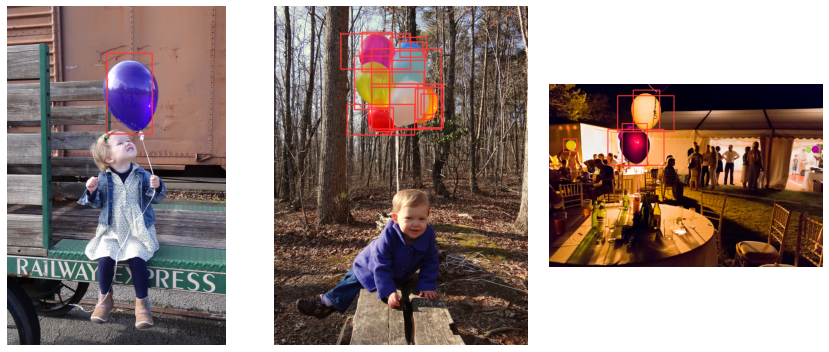

In [30]:
imgs = val_img[:3]
results = model(imgs, 640)
results.render(labels=False)  # updates results.imgs with boxes and labels
images = results.imgs
_,axs = plt.subplots(1,len(images), figsize=(12,5))
for ax, im in zip(axs, images):
    ax.imshow(im);ax.axis('off')
plt.tight_layout();plt.show();

Отметим, что модели семейства `YOLO` также могут быть обучены с ипользованием `PyTorch`. Функци потерь предусмотренная для этого может быть найдена в модуле `utils` класс `ComputeLoss`.

**Учебное задание**

**Дано**: набор изобржений `test_.zip`, аналогично работам 5-8.

**Задание**: достичь точности mAP менее **70%** на тестовом наборе данных `balloon` (аналогично показананому примеру). 

**Результат** должен быть подан в виде фала формата `.json`, так, как это показано ниже. 


In [31]:
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1MY6oQ5y0JdS3-QWOpXbZc9hOBajVLNIb' -O test_.zip
!unzip test_.zip  
!rm test_.zip


--2022-06-06 13:57:05--  https://drive.google.com/uc?export=download&id=1MY6oQ5y0JdS3-QWOpXbZc9hOBajVLNIb
Resolving drive.google.com (drive.google.com)... 142.250.4.138, 142.250.4.100, 142.250.4.102, ...
Connecting to drive.google.com (drive.google.com)|142.250.4.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-58-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/lq7s47k07fg5tonnoev7lhp1la7rav7h/1654523775000/11415097040659511675/*/1MY6oQ5y0JdS3-QWOpXbZc9hOBajVLNIb?e=download [following]
--2022-06-06 13:57:08--  https://doc-0s-58-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/lq7s47k07fg5tonnoev7lhp1la7rav7h/1654523775000/11415097040659511675/*/1MY6oQ5y0JdS3-QWOpXbZc9hOBajVLNIb?e=download
Resolving doc-0s-58-docs.googleusercontent.com (doc-0s-58-docs.googleusercontent.com)... 172.217.194.132, 2404:6800:4003:c04::84
Connecting to doc-0s-58-docs.googleusercontent.com (doc-0s-58-docs.go

In [32]:
imgs_dir =os.path.join(os.getcwd(),'demo_')
imgs = [os.path.join(imgs_dir, fname) for fname in os.listdir(imgs_dir) ]
# Inference
results = model(imgs, 640, augment=True)

In [41]:
import pandas as pd
from PIL import Image
%cd /content/
res = results.xywh
sub = pd.DataFrame()
for fname, res_ in zip(imgs, results.pandas().xywhn):
    sub = sub.append({'file':os.path.split(fname)[-1],
                      'res':res_.values[:,:4].astype(float),
                      'conf':res_.values[:,4].astype(float),
                      'shape': Image.open(fname).size[::-1]
                      }, 
                     ignore_index=True)

sub.to_json('submission.json',orient='table',force_ascii = False)

/content


In [42]:
from google.colab import files

files.download('/content/submission.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [43]:
res_.values[:,4]

array([0.8770342469215393, 0.5838841795921326, 0.318168967962265], dtype=object)